In [358]:
import networkx as nx
from random import randrange as randint
from random import random as randfloat
from random import choice
import matplotlib.pyplot as plt
from statistics import mean
from numpy import logspace

### Task 1: graph generators:

In [385]:
def erdos_renyi(nodes: int, edges: int):
    if edges > (nodes * nodes - 1)/2:
        return nx.Graph()
    er = nx.Graph()
    for i in range(nodes):
        er.add_node(i)
    edge_set = set()
    while len(edge_set) < edges: #will probably choke for near full graphs
        i = randint(nodes)
        j = randint(nodes)
        if i == j:
            pass
        else:
            edge_set.add(tuple(sorted([i, j])))
    for edge in edge_set:
        er.add_edge(*edge)
    return er


def gilbert(nodes: int, prob: float):
    g = nx.Graph()
    for i in range(nodes):
        g.add_node(i)
    for src in range(nodes):
        for dst in range(src+1, nodes):
            if randfloat() < prob:
                g.add_edge(src, dst)
    return g


def watts_strogatz(nodes, k, beta):
    ws = nx.Graph()
    for i in range(nodes):
        ws.add_node(i)
    for i in range(nodes):
        for j in range(1, k+1):
            ws.add_edge(i, (i-j)%nodes)
    for src, dst in ws.edges:
        if randfloat() < beta:
            new_dst = choice(tuple(set(range(i))-set([edge[1] for edge in ws.edges(src)])))
            ws.remove_edge(src, dst)
            ws.add_edge(src, new_dst)
    return ws


I actually think I should rewrite the above using sets of existing/nonexisting nodes. That way adding/deleting nodes is just switching between the two sets

In [230]:
er = erdos_renyi(20000, 30)
#nx.draw_kamada_kawai(er, with_labels = True)

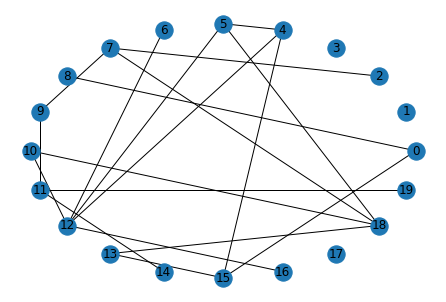

In [236]:
g = gilbert(20, .10)
nx.draw_circular(g, with_labels = True)

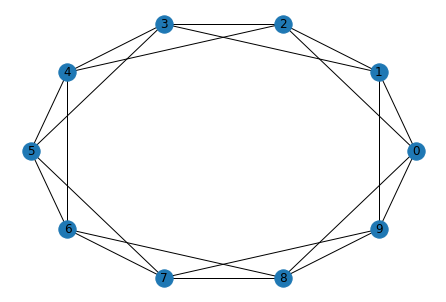

In [231]:
nx.draw_circular(watts_strogatz(10, 2, 0), with_labels = True)
watts_strogatz(20000, 2, 3)

For the next part: I'll calculate some characteristics for these graphs:
```py
watts_strogatz(20000, 2, 0.11)
gilbert(20000, 0.0002000100005)
erdos_renyi(20000, 40000)
```
Reasoning:
I'm taking an arbitral N = 20 000 for the results to be somewhat accurate. From there I'm counting number of edges that Watts-Strogatz model with k = 4 (according to the documentation, 2 according to my implementation) will generate: $\frac{n*4}{2}$ &rarr; 40 000. Which is what I need for Erdős–Rényi. From this I calculate percentage for Gilbert - there could be $\frac{n*(n-1)}{2}$ possible edges, so chance for an edge to appear is $\frac{n*4}{n*(n-1)}$

In [334]:
er = erdos_renyi(20000, 40000)
g = gilbert(20000, 0.00020001001)
ws = watts_strogatz(20000, 2, 0.11)

er_degrees_count = sorted([d for n, d in er.degree()], reverse=True)
g_degrees_count = sorted([d for n, d in g.degree()], reverse=True)
ws_degrees_count = sorted([d for n, d in ws.degree()], reverse=True)

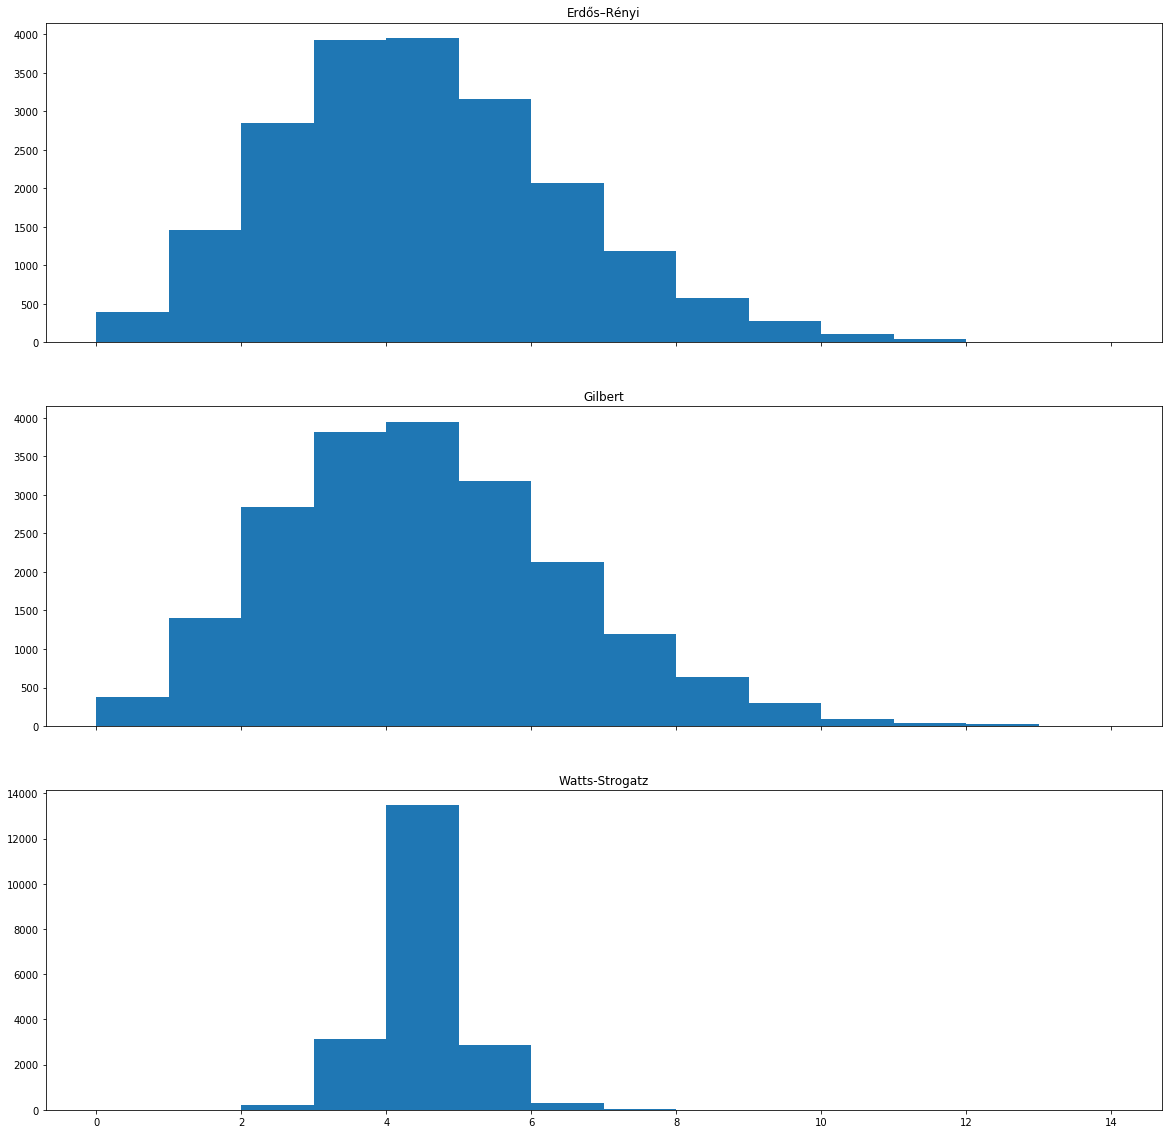

In [335]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.hist(er_degrees_count, bins=range(0,15))#, log=True)
ax1.set_title('Erdős–Rényi')
ax2.hist(g_degrees_count, bins=range(0,15))#, log=True)
ax2.set_title('Gilbert')
ax3.hist(ws_degrees_count, bins=range(0,15))# , log=True)
ax3.set_title('Watts-Strogatz')
fig.set_size_inches(20, 20, forward=True)


In [336]:
print("Average degree:")
print(f"ER: {mean([d for n, d in er.degree()])}    G: {mean([d for n, d in g.degree()])}    WS: {mean([d for n, d in ws.degree()])}")


Average degree:
ER: 4    G: 4.0468    WS: 4


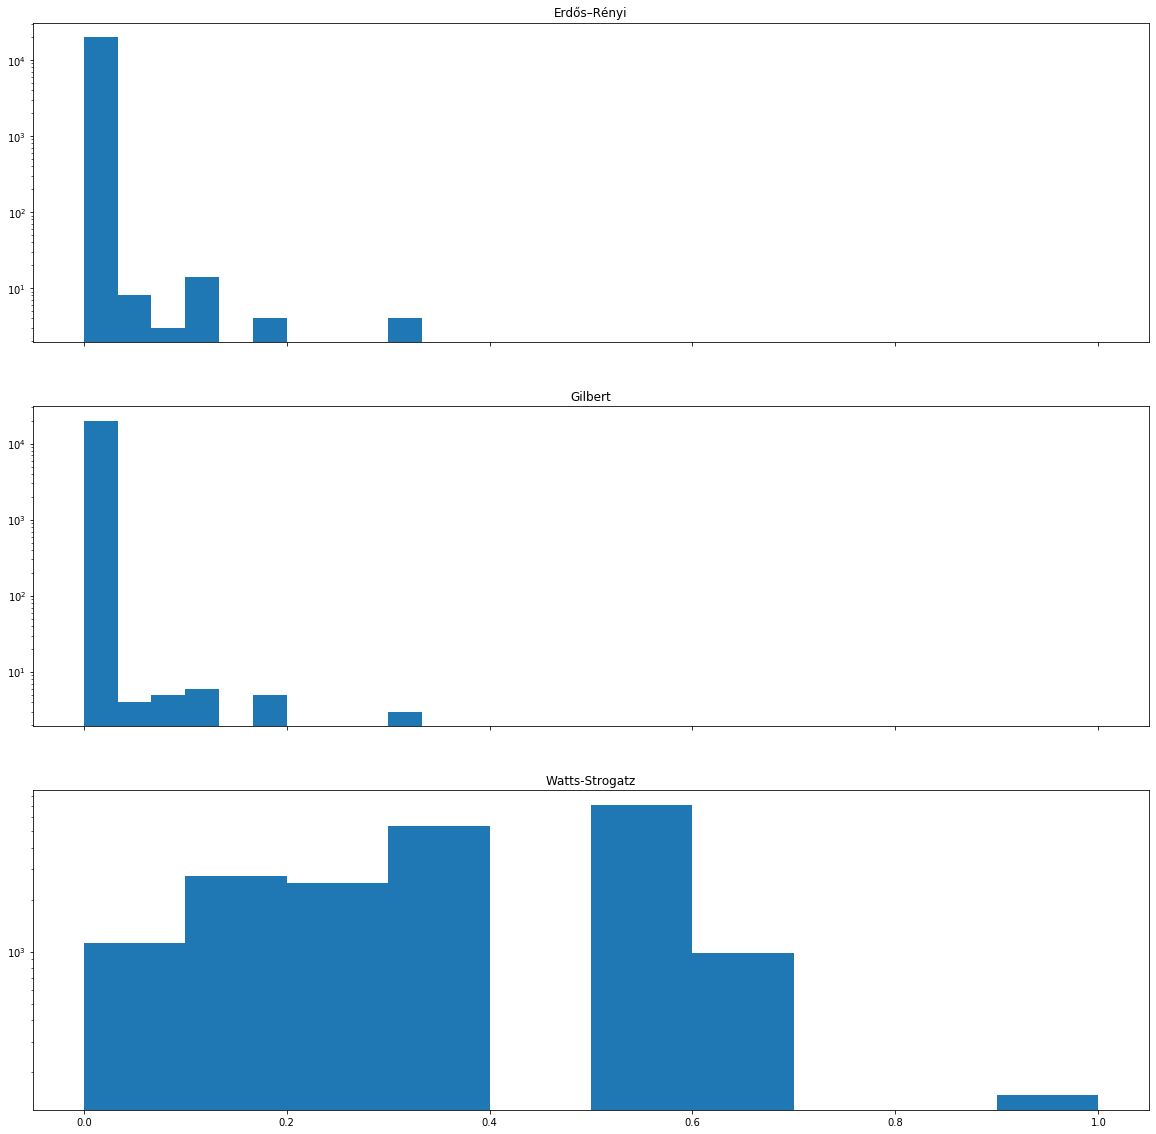

In [337]:
er_clustering_coeff = sorted([d for d in nx.clustering(er).values()], reverse=True)
g_clustering_coeff = sorted([d for d in nx.clustering(g).values()], reverse=True)
ws_clustering_coeff = sorted([d for d in nx.clustering(ws).values()], reverse=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.hist(er_clustering_coeff, bins=[1/i for i in range(1,10)].reverse(), log=True)
ax1.set_title('Erdős–Rényi')
ax2.hist(g_clustering_coeff, bins=[1/i for i in range(1,10)].reverse(), log=True)
ax2.set_title('Gilbert')
ax3.hist(ws_clustering_coeff, bins=[1/i for i in range(1,10)].reverse(), log=True)
ax3.set_title('Watts-Strogatz')
fig.set_size_inches(20, 20, forward=True)


In [423]:
print("Clustering coefficient:")
print(f"ER: {nx.average_clustering(er):9.6f}    G: {nx.average_clustering(g):9.6f}    WS: {nx.average_clustering(ws):9.6f}")


Clustering coefficient:
ER:  0.000201    G:  0.000152    WS:  0.361555


Can't do shortest paths as graphs don't turn out connected for some reason.

print("Diameter:")
print(f"ER: {nx.diameter(er)}    G: {nx.diameter(g)}    WS: {nx.diameter(ws)} ")


In [ ]:
nx.diameter(ws)

### Task 2: WS model analysis

In [425]:
beta_values = logspace(-3, 0, 40)
models4 = [watts_strogatz(1000, 2, beta) for beta in beta_values]
models8 = [watts_strogatz(1000, 4, beta) for beta in beta_values]


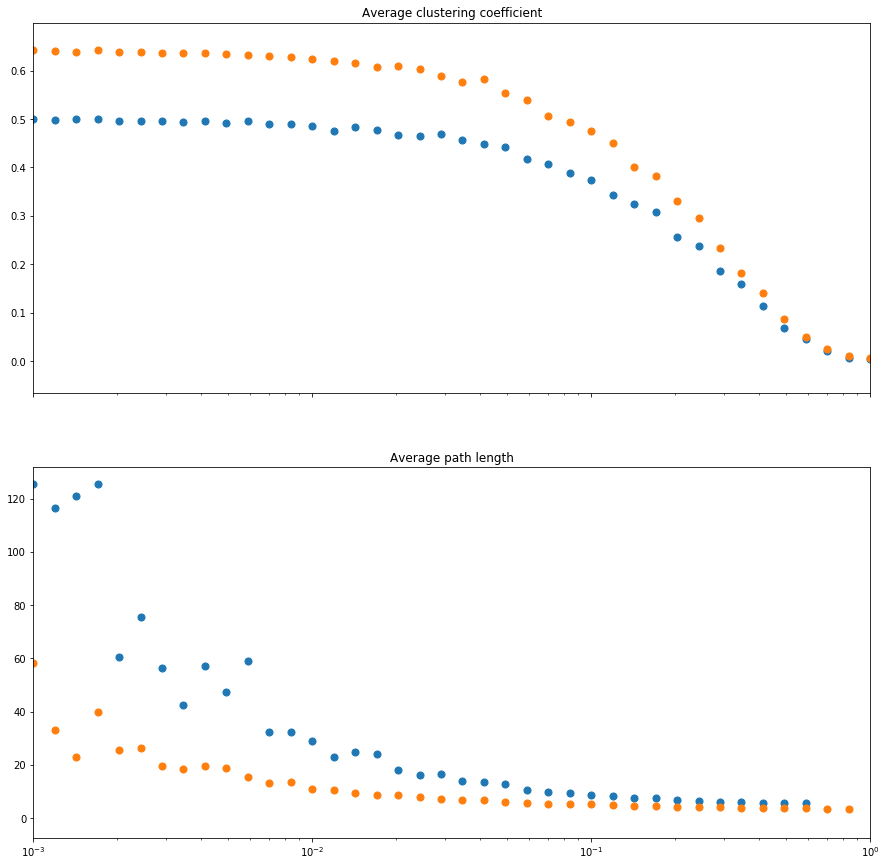

In [447]:
def aspl(graph):
    try:
        return nx.average_shortest_path_length(graph) 
    except:
        return None

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(beta_values, [nx.average_clustering(graph) for graph in models4], s=50)
ax1.scatter(beta_values, [nx.average_clustering(graph) for graph in models8], s=50)
ax1.set_title('Average clustering coefficient')
ax1.set_xscale('log')
ax1.set_xlim(left=10**-3, right=1)

ax2.scatter(beta_values, [aspl(graph) for graph in models4], s=50)
ax2.scatter(beta_values, [aspl(graph) for graph in models8], s=50)
ax2.set_title('Average path length')

fig.set_size_inches(13, 13, forward=True)

In [442]:
nx.average_shortest_path_length(models4[2])

120.9191951951952

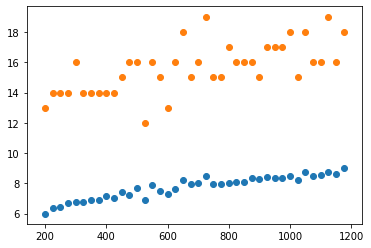

In [457]:
def diameter_wrap(graph):
    try:
        return nx.diameter(graph) 
    except:
        return None
    
n_values = range(200,1200,25)
models = [watts_strogatz(n, 2, 0.11) for n in n_values]
plt.scatter(n_values, [aspl(graph) for graph in models])
plt.scatter(n_values, [diameter_wrap(graph) for graph in models])
